In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

from selective_search import selective_search
import skimage.io

from rcnn import *
from nms import *
from vis import *

Using TensorFlow backend.


In [3]:
def extract_boxes(img, n):
    """
    Uses Selective Search to extract the top N boxes from the image
    
    Args:
        img (ndarray): The image to extract boxes from
        n (int): The maximum number of boxes to return
    Returns:
        The extracted list of boxes
    """
    # Modes = "single", "fast", "quality"
    print("Extracting boxes... ", end="")
    boxes = selective_search(img, mode="fast", random=False)
    boxes = [(int(box[0]), int(box[1]), int(box[2]), int(box[3])) for box in boxes]
    print("Done.")

    # Only return first N boxes
    return boxes[:n]

In [4]:
def per_region_features(model, img, boxes):
    """
    
    Args:
        model (Model): The model to use
        img (ndarray): The image to extract features from
        boxes (list of tuple): The (x1, y1, x2, y2) boxes
    Returns:
        -
    """
    feat = features(img, boxes, model)
    feat = lX_to_fcX(feat, len(model.layers), 8, model)
    feat_norm = model.feat_norm_mean
    feat = scale_features(feat, feat_norm)
    return feat

In [5]:
def prune_boxes_hedging(boxes, scores, categories):
    pass

In [104]:
MAX_CATEGORIES = 100

def prune_boxes(boxes, scores):
    print("Prune boxes... ", end="")
    
    # Find scores > 0
    pos_scores = np.argwhere(scores > 0)
    categories = np.unique(pos_scores[:, 1])
    
    # If too many categories, choose the N categories with the highest scores
    if len(categories) > MAX_CATEGORIES:
        best_scores = np.max(scores[:, categories], axis=0)
        best_scores = [(score, category) for score, category in zip(best_scores, categories)]
        best_scores.sort(reverse=True)
        categories = [category for _, category in best_scores[:MAX_CATEGORIES]]

    # Choose the best boxes that don't overlap too much within each class
    best_boxes, category_ids, best_scores = [], [], []
    for category in categories:
        idxs = pos_scores[:, 0][pos_scores[:, 1] == category]
        category_scores = scores[idxs, category]
        scored_boxes = [(box, score) for box, score in zip([boxes[idx] for idx in idxs], category_scores)]
        
        keep = non_max_suppression(scored_boxes, 0.1)
        best_boxes += [scored_boxes[idx] for idx in keep]
        category_ids += [category for _ in keep]
        best_scores += [category_scores[idx] for idx in keep]
        #?
        
    if not best_boxes:
        return [], [], []
        
    # Choose the best boxes between classes
    #print(best_boxes[:10])
    keep = non_max_suppression(best_boxes, 0.4)
    category_ids = [category_ids[idx] for idx in keep]
    best_boxes = [best_boxes[idx] for idx in keep]
    best_scores = [best_scores[idx] for idx in keep]
        
    print("Done.")
    return best_boxes, category_ids, best_scores

Extracting boxes... Done.
Extract regions... Done.
Computing features... Done
Prune boxes... Done.


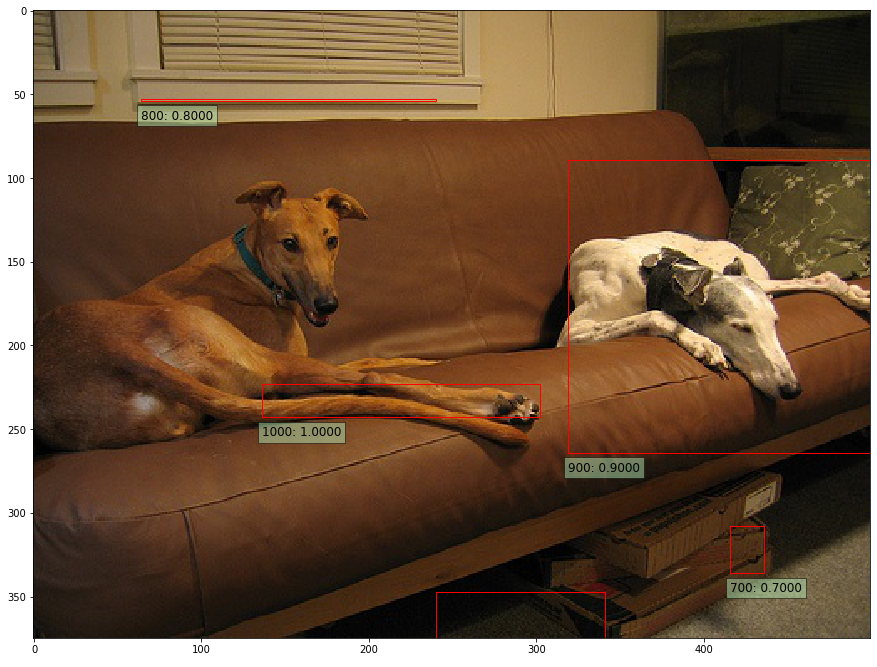

In [108]:
# Load model
model = load_model("../models/model.pkl")

# Get boxes
img = skimage.io.imread("../data/ex_img.jpg")
num_boxes = 1024
boxes = extract_boxes(img, num_boxes)

# Extract per region features and scores
scores = per_region_features(model, img, boxes)
scores[50][1000] = 1.0
scores[80][900] = 0.9
scores[400][800] = 0.8
scores[750][700] = 0.7
scores[100][600] = 0.6
scores[900][500] = 0.5

# Prune boxes based on scores
boxes, category_ids, scores = prune_boxes(boxes, scores)

# Show detections
m = min(5, len(category_ids))
show_detections(img, boxes[:m], category_ids[:m])